<a href="https://colab.research.google.com/github/sethitanmay1/Book-recommendation-system/blob/main/Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from scipy.sparse import csr_matrix

### 1. Data loading and reading

The data used for this project consist of 5 different datasets, which are loaded and presented above: 

In [ ]:
books = pd.read_csv('https://raw.githubusercontent.com/sethitanmay1/Book-recommendation-system/main/books.csv')
ratings = pd.read_csv('https://raw.githubusercontent.com/sethitanmay1/Book-recommendation-system/main/ratings.csv')
tags = pd.read_csv('https://raw.githubusercontent.com/sethitanmay1/Book-recommendation-system/main/tags.csv')
bookTags = pd.read_csv('https://raw.githubusercontent.com/sethitanmay1/Book-recommendation-system/main/book_tags.csv')
toRead = pd.read_csv('https://raw.githubusercontent.com/sethitanmay1/Book-recommendation-system/main/to_read.csv')

<br>

--------

<br>

**1) Books** contains all the information about the rated books, including author, title, book ID, publication year, average rating, etc.

In [ ]:
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [ ]:
books.shape    # 10.000 rows x 23 columns imported

(10000, 23)

In [ ]:
len(books.id.unique())  # There is information for 10.000 different books in total

10000

With the purpose of having a quick look at what are the books with the highest average rating, let's sort the dataset by average rating, selecting only the most relevant out of the 23 columns.
Apparently, the selected sample of users seem to like quite a lot Bill Watterson's 'Calvin and Hobbes' comic series.

In [ ]:
# Book with the highest average rating:

books[['id', 'book_id', 'authors', 'title', 'average_rating', 'ratings_count']] \
     .sort_values('average_rating', ascending = False).head(20)

,id,book_id,authors,title,average_rating,ratings_count
3627,3628,24812,Bill Watterson,The Complete Calvin and Hobbes,4.82,28900
3274,3275,8,"J.K. Rowling, Mary GrandPré","Harry Potter Boxed Set, Books 1-5 (Harry Potte...",4.77,33220
861,862,17332218,Brandon Sanderson,"Words of Radiance (The Stormlight Archive, #2)",4.77,73572
8853,8854,95602,Francine Rivers,Mark of the Lion Trilogy,4.76,9081
7946,7947,5031805,"Anonymous, Lane T. Dennis, Wayne A. Grudem",ESV Study Bible,4.76,8953
4482,4483,24814,Bill Watterson,It's a Magical World: A Calvin and Hobbes Coll...,4.75,22351
6360,6361,70489,Bill Watterson,There's Treasure Everywhere: A Calvin and Hobb...,4.74,16766
421,422,862041,J.K. Rowling,"Harry Potter Boxset (Harry Potter, #1-7)",4.74,190050
3752,3753,10,J.K. Rowling,"Harry Potter Collection (Harry Potter, #1-6)",4.73,24618
6919,6920,24815,Bill Watterson,The Indispensable Calvin and Hobbes,4.73,14597


<br>

--------

<br>

**2) Ratings** includes all the rates given by our selected group of users to the books they have chosen to rate.

In [ ]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [ ]:
ratings.shape  # 981.756 rows x 3 columns imported

(981756, 3)

In [ ]:
len(ratings.book_id.unique())  # There are ratings for 10.000 different books in total

10000

In [ ]:
len(ratings.user_id.unique())  # Ratings to these 10k books have been given by 53.424 unique users

53424

<br>

------

<br>

**3) Tags** collects all the tags included in 'bookTags' and explains their meaning.

In [ ]:
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [ ]:
tags.head()   # 34.252 rows x 2 columns importedtags.shape    

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [ ]:
len(tags.tag_id.unique())  # There are 34.252 different tags, which means no duplicates

34252

<br>

-----

**4) Book Tags** contains all the tags associated to each and every book included in the analysis.

In [ ]:
bookTags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [ ]:
bookTags.shape    # 999.912 rows imported x 3 columns imported

(999912, 3)

In [ ]:
len(bookTags.goodreads_book_id.unique())  # As expected, there are 10.000 books in total

10000

In [ ]:
len(bookTags.tag_id.unique())  # As expected, there are 34.252 different tags in total

34252

<br>

-------

<br>

**5) to Read** indicates all the books that have been flagged as 'to read' by the readers included in the analysis.

In [ ]:
toRead.head()

,user_id,book_id
0,1,112
1,1,235
2,1,533
3,1,1198
4,1,1874


In [ ]:
toRead.shape    # 912.705 rows x 2 columns imported

(912705, 2)

In [ ]:
len(toRead.book_id.unique())  # 9.986 different books have been given the 'toRead' tag

9986

In [ ]:
len(toRead.user_id.unique())   # 48.871 unique users have used the 'toRead' tag to flag at least one the 10k books

48871

<br>

--------

<br>

#### 1.1 Adding own personal ratings to the dataset

In order to make the analysis more interesting and easier to follow, it is good to select a specific user and keep track of him along the whole process, and see what recommendations the system will be able to give him. 
For this purpose, I have leveraged my own personal Goodreads account, scraping all the ratings I have been given, since I had a Goodreads account, to the books I have read.

The ratings are stored in the 'maxRatings.csv' file, that I have created through the carping process included in the previous notebook.

In [ ]:
maxRatings = pd.read_csv('https://raw.githubusercontent.com/sethitanmay1/Book-recommendation-system/main/maxRatings.csv')

In [ ]:
maxRatings.head()

,Unnamed: 0,title,rating
0,0,La ragazza di Bube,3
1,1,Crash,3
2,2,"Flow My Tears, the Policeman Said",5
3,3,Lost in Music,3
4,4,Things The Grandchildren Should Know,4


In [ ]:
maxRatings.shape    # 97 rows x 3 columns imported

(97, 3)

For the purpose of the analysis, we have to assign a user ID to my account. In the following lines, I have checked that the maximum userID in the dataset is 53424, hence I have assigned the user number 55000 to my account, and appended a column that indicates it.

In [ ]:
max(ratings['user_id'])

53424

In [ ]:
maxRatings['user_id'] = 55000

In order to see how many of the 97 books I have actually read and rated are in the books dataset selected for this analysis, let's merge maxRatings with the rating dataset.

In [ ]:
maxRatingsWithId = pd.merge(maxRatings, books, on = 'title')
maxRatingsWithId.head()

,Unnamed: 0,title,rating,user_id,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,Crash,3,55000,7232,70241,70241,68058,81,312420331,9.780312e+12,J.G. Ballard,1973.0,Crash,en-CA,3.58,13217,15187,925,825,1804,3900,5091,3567,https://images.gr-assets.com/books/1281416649m...,https://images.gr-assets.com/books/1281416649s...
1,2,"Flow My Tears, the Policeman Said",5,55000,4326,22584,22584,949696,92,1857983416,9.781858e+12,Philip K. Dick,1974.0,"Flow My Tears, the Policeman Said",eng,3.93,22063,25396,1187,206,1104,6014,10985,7087,https://images.gr-assets.com/books/1398026028m...,https://images.gr-assets.com/books/1398026028s...
2,6,Chronicle of a Death Foretold,5,55000,1239,23878,23878,59137,269,140003471X,9.781400e+12,"Gabriel García Márquez, Gregory Rabassa",1981.0,Crónica de una muerte anunciada,eng,3.95,56200,81653,3996,955,4077,18369,33190,25062,https://images.gr-assets.com/books/1430736599m...,https://images.gr-assets.com/books/1430736599s...
3,7,The Taming of the Shrew,3,55000,773,47021,47021,3152341,689,074347757X,9.780743e+12,William Shakespeare,1593.0,The Taming of the Shrew,en-US,3.81,126318,134240,2370,2869,9611,35666,47453,38641,https://images.gr-assets.com/books/1327935253m...,https://images.gr-assets.com/books/1327935253s...
4,8,The Merchant of Venice,3,55000,839,24128,24128,2682703,1088,743477561,9.780743e+12,"William Shakespeare, Robert Jackson, ...",1596.0,The Merchant of Venice,eng,3.78,115621,128289,2616,1925,9212,36917,46745,33490,https://images.gr-assets.com/books/1327871054m...,https://images.gr-assets.com/books/1327871054s...


Next step will be to append my ratings to the ratings dataset. To do so, firstly I have to recondut maxRatings dataset to the exact same layout and format as the ratings one. Hence, I select only the columns needed, renaming one of them, given that 'id' in the 'books' dataset corresponds to 'book_id' in the rating dataset.

In [ ]:
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [ ]:
maxRatingsWithId = maxRatingsWithId[['id', 'user_id', 'rating']] \
                    .rename(columns = {'id' : 'book_id'})

In [ ]:
maxRatingsWithId.head()

,book_id,user_id,rating
0,7232,55000,3
1,4326,55000,5
2,1239,55000,5
3,773,55000,3
4,839,55000,3


In [ ]:
ratings = ratings.append(maxRatingsWithId)

In [ ]:
len(ratings.user_id.unique())    # As expected, now ratings has one more unique user id

53425

<br>

------

Taking a closer look at the ratings dataset I have realized that there are several users who have rated the same book more than once, for whatever reason.
For this reason, we will proceed to erase those duplicated ratings from the rating table: for those user-book pairs that have more than 1 rating we will then keep only one record, indicating the average of the given ratings.

In [ ]:
# The following table will show which pair of user-book have more than 1 rating in the dataset: 

userRatesPerBookCount = ratings.groupby(['user_id', 'book_id'], as_index = False).count().sort_values('rating', ascending = False)
userRatesPerBookCount.head(15)

,user_id,book_id,rating
59787,3204,8946,5
95001,5091,8946,4
572,42,8946,4
42643,2308,8946,4
665335,34548,7420,4
729574,38259,3996,4
81315,4359,2515,4
11033,691,6472,4
20901,1248,8946,3
468001,23851,3848,3


In [ ]:
# Let's double check if this is true:

ratings[(ratings.user_id == 3204) & (ratings.book_id == 8946)]  

,book_id,user_id,rating
883706,8946,3204,5
883707,8946,3204,5
883708,8946,3204,5
883709,8946,3204,5
883710,8946,3204,4


In [ ]:
# Here I calculate the rating mean per user and book, so that I can later replace the mean to the rating value
# and get rid of the duplicates rows

userRatesPerBookMean = ratings.groupby(['user_id', 'book_id'], as_index = False).mean().round(0).sort_values('rating', ascending = False)
userRatesPerBookMean.head(15)

,user_id,book_id,rating
354506,17855,8511,5.0
386280,19581,9665,5.0
821433,43668,1336,5.0
821434,43668,1473,5.0
821435,43668,1483,5.0
821437,43668,1513,5.0
821438,43668,1556,5.0
821439,43668,1585,5.0
821442,43668,1840,5.0
821444,43668,1932,5.0


In [ ]:
# Let's double check if that worked ok:

userRatesPerBookMean[(userRatesPerBookMean.user_id == 3204) & (userRatesPerBookMean.book_id == 8946)]  

,user_id,book_id,rating
59787,3204,8946,5.0


In [ ]:
# We create now a table grouped by user and book pair, calculating mean and number of rating that a user has made for the
# same book

ratings['count'] = ratings['rating']

userRatesPerBook = ratings.groupby(['user_id', 'book_id'], as_index = False) \
                   .agg({'rating' : 'mean', 'count' : 'count'}) \
                   .rename(columns = {'rating':'mean'}) \
                   .sort_values('count', ascending = False)

ratings = ratings.drop(['count'], axis = 1)
            
userRatesPerBook['mean'] = userRatesPerBook['mean'].round(0)
userRatesPerBook.head()

,user_id,book_id,mean,count
59787,3204,8946,5.0,5
95001,5091,8946,5.0,4
572,42,8946,5.0,4
42643,2308,8946,5.0,4
665335,34548,7420,5.0,4


In [ ]:
# Now I append the mean and count per each user and book to the ratings table:

ratings = pd.merge(ratings, userRatesPerBook, on = ['user_id', 'book_id'])
ratings.head()

,book_id,user_id,rating,mean,count
0,1,314,5,5.0,1
1,1,439,3,3.0,1
2,1,588,5,5.0,1
3,1,1169,4,4.0,1
4,1,1185,4,4.0,1


In [ ]:
ratings.sort_values('count', ascending = False).head(15)

,book_id,user_id,rating,mean,count
883708,8946,3204,5,5.0,5
883706,8946,3204,5,5.0,5
883709,8946,3204,5,5.0,5
883707,8946,3204,5,5.0,5
883710,8946,3204,4,5.0,5
251243,2515,4359,5,5.0,4
251242,2515,4359,5,5.0,4
251241,2515,4359,5,5.0,4
251244,2515,4359,5,5.0,4
883700,8946,2308,5,5.0,4


In [ ]:
ratings.shape    # 981.820 rows x 5 columns

(981819, 5)

In [ ]:
# We can now drop the duplicates records for the combination user/book with more than 1 rating

ratings = ratings.drop_duplicates(subset = ['book_id', 'user_id'], keep = 'first', inplace = False)\
                                  .sort_values('count', ascending = False)

In [ ]:
ratings = ratings.drop(['rating', 'count'], axis = 1)

In [ ]:
ratings.head()

,book_id,user_id,mean
883706,8946,3204,5.0
883651,8946,42,5.0
251241,2515,4359,5.0
644166,6472,691,5.0
883717,8946,5091,5.0


In [ ]:
ratings.shape  # 979.542 rows x 3 columns: 2.278 records removed

(979541, 3)

In [ ]:
# I restore the 'ratings' table column names as they were prior to the modification I have made
ratings.columns = ['book_id', 'user_id', 'rating']

In [ ]:
ratings.columns

Index(['book_id', 'user_id', 'rating'], dtype='object')

<br>

With the purpose of making more relevant recommendations, let's have a look at what is the ratings distribution per users: in other words, let's see if there are users who have rated very few books.

In [ ]:
ratesPerUser = ratings[['user_id', 'rating']].groupby(['user_id'], as_index = False) \
                      .count() \
                      .rename(columns = {'rating' : 'totalRatings'}) \
                      .sort_values('totalRatings', ascending = False)

ratesPerUser.head(10)

,user_id,totalRatings
12873,12874,200
30943,30944,200
52035,52036,199
28157,28158,199
12380,12381,199
45553,45554,197
6629,6630,197
19728,19729,196
24142,24143,196
15603,15604,196


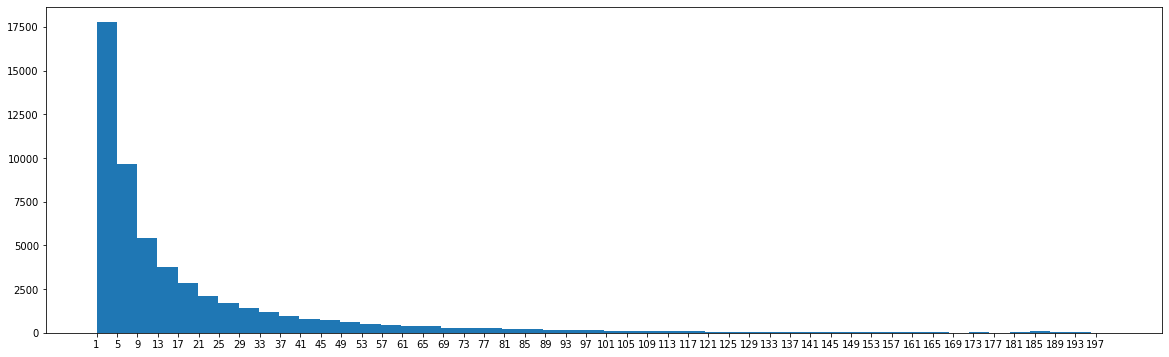

In [ ]:
plt.rcParams['figure.figsize'] = [20, 6]
plt.hist(ratesPerUser['totalRatings'], bins = 50)
plt.xticks(np.arange(min(ratesPerUser['totalRatings']), max(ratesPerUser['totalRatings'])+1, 4.0))
plt.show()

The histogram above shows how many users have rated only 1 to 15 books. Considered that we are using only a subset (10k) of all the books listed in Goodreads, it will be pretty difficult to give accurate recommendation to users with that few ratings.  
Cosnidering also the fact that this project has rather an illustrative purpose, I have decided to include only user that have rated at least 20 of the 10K books included in the analysis.

In [ ]:
ratings = pd.merge(ratings, ratesPerUser, on = ['user_id'])

In [ ]:
ratings.sort_values('totalRatings', ascending = False).head(10)

,book_id,user_id,rating,totalRatings
977744,21,30944,3.0,200
488867,102,12874,2.0,200
488856,576,12874,2.0,200
488857,579,12874,3.0,200
488858,485,12874,3.0,200
488859,498,12874,3.0,200
488860,497,12874,3.0,200
488861,465,12874,4.0,200
488862,479,12874,3.0,200
488863,471,12874,3.0,200


In [ ]:
# Keeping only users with more than a 'minimum' of ratings
minimumRatings = ratings.totalRatings <= 20
np.sum(minimumRatings)

272086

In [ ]:
ratings = ratings[-minimumRatings]
len(ratings)   # only 707.456 ratings have been kept

707455

In [ ]:
len(ratings.user_id.unique())  # total of remaining users after removing the ones with less than the established minimum

13972

In [ ]:
len(ratings.book_id.unique())  # total of remaining books after removing users with less than the established minimum

9998

Then I had a look at the same thing but about the books: how many books have very few ratings? Looking at the results, I have decided - for the same reason as above, that is to avoid 'obscure' recommendations of books that only few users have read - to remove books with less than 30 ratings received.

In [ ]:
ratesPerBook = ratings[['book_id', 'rating']].groupby(['book_id'], as_index = False) \
                      .count() \
                      .rename(columns = {'rating' : 'receivedRatings'}) \
                      .sort_values('receivedRatings', ascending = False)

ratesPerBook.tail()

,book_id,receivedRatings
9342,9345,2
9855,9858,1
9087,9090,1
8802,8804,1
8371,8372,1


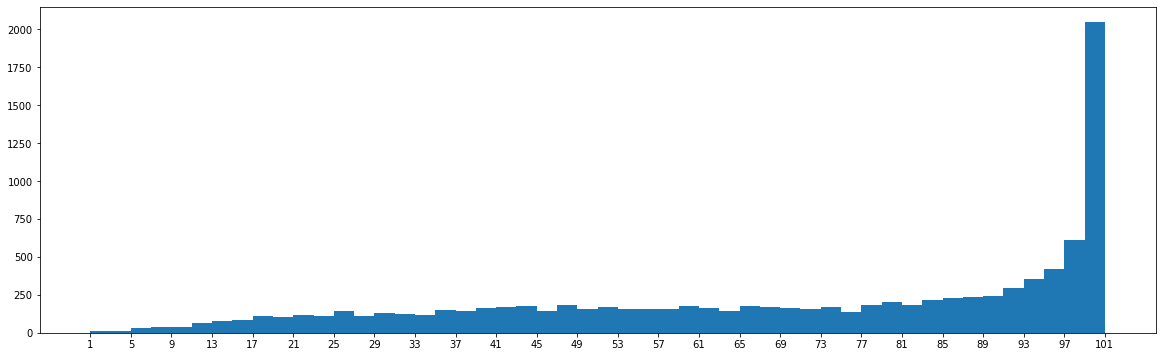

In [ ]:
plt.rcParams['figure.figsize'] = [20, 6]
plt.hist(ratesPerBook['receivedRatings'], bins = 50)
plt.xticks(np.arange(min(ratesPerBook['receivedRatings']), max(ratesPerBook['receivedRatings'])+1, 4.0))
plt.show()

In [ ]:
ratings = pd.merge(ratings, ratesPerBook, on = ['book_id'])

In [ ]:
# Keeping only books with more than a 'minimum' of ratings received

minimumReceived = ratings.receivedRatings < 30
np.sum(minimumReceived)

21710

In [ ]:
ratings = ratings[-minimumReceived]
len(ratings)

685745

In [ ]:
len(ratings.user_id.unique())   # total of remaining users after removing the ones with less than the established minimum

13971

In [ ]:
len(ratings.book_id.unique())    # total of remaining books after removing the ones with less than the established minimum

8885

In [ ]:
ratings.shape

(685745, 5)

<br>

-------

<br>

To start off, I have tried to calculate a first type of Top-N recommendation: the top rated books. 
After having removed the books and users above, the result doesn't change much compared to the what shown right after the  data loading: Bill Watterson and his Calvin and Hobbes is still dominating the chart.

In [ ]:
# For illustrative purpose, let's first grab author and title for the books dataset:
showingTitles = pd.merge(ratings, books[['id', 'authors', 'title']], how = 'left', left_on = ['book_id'], right_on = ['id'])

In [ ]:
topRated = showingTitles.groupby(['book_id'], as_index = False) \
                      .agg({'rating' : 'mean', \
                           'authors': 'first', \
                           'title' : 'first'})
topRated.sort_values('rating', ascending = False).head(10)

,book_id,rating,authors,title
6631,6920,4.806452,Bill Watterson,The Indispensable Calvin and Hobbes
8622,9566,4.800000,Bill Watterson,Attack of the Deranged Mutant Killer Monster S...
5094,5207,4.774648,Bill Watterson,The Days Are Just Packed: A Calvin and Hobbes ...
8237,8978,4.767857,Bill Watterson,The Revenge of the Baby-Sat
4061,4107,4.750000,"Andrew Williamson, Andrew Williamson",Harry Potter: A Pop-Up Book: Based on the Film...
6341,6590,4.750000,Bill Watterson,The Authoritative Calvin and Hobbes: A Calvin ...
7602,8109,4.745763,"Neil Gaiman, Mike Dringenberg, Chris Bachalo, ...","The Absolute Sandman, Volume One"
6142,6361,4.738095,Bill Watterson,There's Treasure Everywhere: A Calvin and Hobb...
4422,4483,4.738095,Bill Watterson,It's a Magical World: A Calvin and Hobbes Coll...
3596,3628,4.734694,Bill Watterson,The Complete Calvin and Hobbes


<br>

---------

<br>

### 2. Content-Based Filtering (Tag-Based)

As long as the first Top-N recommendation created doesn't seem at all to be useful, I have build a "Content-Based" recommendation, leveraging the knowledge we have from the tags dataset using tags and other information from the book metadata.

However, as shown below, the tags dataset contains format-free definition, which include a vast variety of tags. Most of them are not saying much of the book itself and its contect or characteristics (e.g. 'to-read', 'favourite', 'book-I-own', 'made-me-cry', etc).
For this reason I have decide to include only the tags that are representative of the book 'genre' according to Goodreads itself: the tags used in fact are scraped from their genre section and contain a vast variety of tags. The others have been filtered out.

In [ ]:
showingTagName = pd.merge(bookTags, tags, on = 'tag_id')
showingTagName.sort_values('goodreads_book_id').head(20)

,goodreads_book_id,tag_id,count,tag_name
0,1,30574,167697,to-read
258362,1,33165,338,youth
250046,1,17213,347,kindle
246919,1,27535,348,shelfari-favorites
245888,1,16799,351,juvenile
245375,1,18851,354,made-me-cry
240136,1,25151,364,read-in-2015
238876,1,11550,368,favorite-series
237950,1,11491,384,faves
237815,1,32654,386,wizards


In [ ]:
mostUsedTags = showingTagName.groupby(['tag_name'], as_index = False) \
                      .agg({'goodreads_book_id' : 'count'}) \
                      .rename(columns = {'goodreads_book_id' : 'number'}) \
                      .sort_values('number', ascending = False)
mostUsedTags.head()

,tag_name,number
30574,to-read,9983
11557,favorites,9881
22743,owned,9858
5207,books-i-own,9799
8717,currently-reading,9776


<br>

So I have used the genres.csv files, which was generated by scraping Goodreads website, and it is shown in the other notebook.

In [ ]:
genres = pd.read_csv('https://raw.githubusercontent.com/sethitanmay1/Book-recommendation-system/main/genres.csv')
genres.head(10)

,Unnamed: 0,tag_name
0,0,art
1,1,biography
2,2,business
3,3,children-s
4,4,christian
5,5,classics
6,6,comics
7,7,cookbooks
8,8,ebooks
9,9,fantasy


In [ ]:
genres.shape    # 1235 rows X 2 columns

(1235, 2)

In [ ]:
# First I convert the genres to a list
genreList = genres['tag_name'].tolist()

In [ ]:
len(genreList)    # 1235 genre-tags have been scraped from Goodreads website

1235

In [ ]:
len(tags.tag_name.unique())   # the original tag dataset included 34.252 tags

34252

In [ ]:
genreTags = tags.loc[tags['tag_name'].isin(genreList)]
len(genreTags)    # 832 tags (of out the 1235) scraped from the Genre Section in Goodreads website are included in the 
                  # original tags table.

832

Then I have merged the bookTags dataset with the genreTags, so that now I have the information of what books in the dataset have been tagged with at least one of the 832 genre-tags used by Goodreads in their genres section.

The idea is then to measure the similarity between each book pair, so that the system will be able to recommend Top-N similar books for any selected title from the ones included in the analysis.
In order to be able to properly perform content based filtering, first I have to put all the tags related to one single book in a single string: each tag must be separated from each other with a space, to be accounted as a single word.
Then I will perform pairwise similarity scores between books.

In [ ]:
mostCommonTags = pd.merge(bookTags, genreTags, on = ['tag_id'])

In [ ]:
stringedTags = mostCommonTags.groupby('goodreads_book_id')['tag_name'].apply(lambda x: "%s" % ' '.join(x)).reset_index()

In [ ]:
stringedTags.head(20)

,goodreads_book_id,tag_name
0,1,fantasy young-adult fiction magic childrens ad...
1,2,fantasy young-adult fiction magic children-s n...
2,3,fantasy young-adult fiction magic childrens ad...
3,5,fantasy young-adult fiction magic childrens ad...
4,6,fantasy young-adult fiction childrens adventur...
5,8,fantasy young-adult fiction magic childrens ad...
6,10,fantasy young-adult fiction magic childrens ad...
7,11,fantasy young-adult fiction adventure classics...
8,13,fantasy young-adult fiction adventure classics...
9,21,fiction humor funny adult space science abando...


In [ ]:
# I go retrieve the author and book information from the book dataset, so that I will be able to actually see
# the title of the book instead of just seeing the id.

stringedTags = pd.merge(stringedTags, books[['book_id', 'authors', 'title']], left_on = ['goodreads_book_id'], \
                       right_on = ['book_id']).drop('book_id', axis = 1)

In [ ]:
stringedTags.head(5)

,goodreads_book_id,tag_name,authors,title
0,1,fantasy young-adult fiction magic childrens ad...,"J.K. Rowling, Mary GrandPré",Harry Potter and the Half-Blood Prince (Harry ...
1,2,fantasy young-adult fiction magic children-s n...,"J.K. Rowling, Mary GrandPré",Harry Potter and the Order of the Phoenix (Har...
2,3,fantasy young-adult fiction magic childrens ad...,"J.K. Rowling, Mary GrandPré",Harry Potter and the Sorcerer's Stone (Harry P...
3,5,fantasy young-adult fiction magic childrens ad...,"J.K. Rowling, Mary GrandPré, Rufus Beck",Harry Potter and the Prisoner of Azkaban (Harr...
4,6,fantasy young-adult fiction childrens adventur...,"J.K. Rowling, Mary GrandPré",Harry Potter and the Goblet of Fire (Harry Pot...


Other than the genre-tags,a very important information that we can add to the stringed tag of each book is the author. Including the author will produce a higher similarity score between 2 books written by the same author, which seems reasonable a as someone who likes a book from an author is most likely going to like also other books from the same person.

In [ ]:
# First of all, I put everything in lowercase and I remove the space between the name and the surname, to make it count
# as one single word all the time.
stringedTags['authors'] = stringedTags['authors'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))

In [ ]:
stringedTags.head(5)

,goodreads_book_id,tag_name,authors,title
0,1,fantasy young-adult fiction magic childrens ad...,"j.k.rowling,marygrandpré",Harry Potter and the Half-Blood Prince (Harry ...
1,2,fantasy young-adult fiction magic children-s n...,"j.k.rowling,marygrandpré",Harry Potter and the Order of the Phoenix (Har...
2,3,fantasy young-adult fiction magic childrens ad...,"j.k.rowling,marygrandpré",Harry Potter and the Sorcerer's Stone (Harry P...
3,5,fantasy young-adult fiction magic childrens ad...,"j.k.rowling,marygrandpré,rufusbeck",Harry Potter and the Prisoner of Azkaban (Harr...
4,6,fantasy young-adult fiction childrens adventur...,"j.k.rowling,marygrandpré",Harry Potter and the Goblet of Fire (Harry Pot...


In [ ]:
# With the same operation, I remove the comma between the names as well
stringedTags['authors'] = stringedTags['authors'].astype('str').apply(lambda x: str.lower(x.replace(",", " ")))

In [ ]:
stringedTags.head(20)

,goodreads_book_id,tag_name,authors,title
0,1,fantasy young-adult fiction magic childrens ad...,j.k.rowling marygrandpré,Harry Potter and the Half-Blood Prince (Harry ...
1,2,fantasy young-adult fiction magic children-s n...,j.k.rowling marygrandpré,Harry Potter and the Order of the Phoenix (Har...
2,3,fantasy young-adult fiction magic childrens ad...,j.k.rowling marygrandpré,Harry Potter and the Sorcerer's Stone (Harry P...
3,5,fantasy young-adult fiction magic childrens ad...,j.k.rowling marygrandpré rufusbeck,Harry Potter and the Prisoner of Azkaban (Harr...
4,6,fantasy young-adult fiction childrens adventur...,j.k.rowling marygrandpré,Harry Potter and the Goblet of Fire (Harry Pot...
5,8,fantasy young-adult fiction magic childrens ad...,j.k.rowling marygrandpré,"Harry Potter Boxed Set, Books 1-5 (Harry Potte..."
6,10,fantasy young-adult fiction magic childrens ad...,j.k.rowling,"Harry Potter Collection (Harry Potter, #1-6)"
7,11,fantasy young-adult fiction adventure classics...,douglasadams,The Hitchhiker's Guide to the Galaxy (Hitchhik...
8,13,fantasy young-adult fiction adventure classics...,douglasadams,The Ultimate Hitchhiker's Guide to the Galaxy
9,21,fiction humor funny adult space science abando...,billbryson,A Short History of Nearly Everything


In [ ]:
# Then I add the author(s) to the stringed genre-tags
stringedTags['all_tags'] = stringedTags['tag_name'] + " " + stringedTags['authors']

In [ ]:
# A example with one of Harry Potter's series book:
stringedTags.all_tags[1]

'fantasy young-adult fiction magic children-s novels paranormal teen witches urban-fantasy supernatural mystery wizards juvenile romance coming-of-age science-fiction-fantasy boarding-school action british-literature young-adult-fantasy j.k.rowling marygrandpré'

Now I use the 'CountVectorizer' function, that will generate a matrix in which the columns represent all the tag-words that I have included in the analysis and the rows represent the books.

From that matrix (the 'tagMatrix'), I have calculated a similarity score between each book pair, choosing the 'cosine' as a metric of distance.

In [ ]:
countVec = CountVectorizer(analyzer = 'word', ngram_range = (1, 2), min_df = 0, stop_words = 'english')

In [ ]:
tagMatrix = countVec.fit_transform(stringedTags['all_tags'])

In [ ]:
tagMatrix

<10000x26750 sparse matrix of type '<class 'numpy.int64'>'
	with 509529 stored elements in Compressed Sparse Row format>

In [ ]:
cosineSim = cosine_similarity(tagMatrix, tagMatrix)

In [ ]:
cosineSim.shape

(10000, 10000)

In [ ]:
cosineSim

array([[1.        , 0.7643608 , 0.92288947, ..., 0.27508955, 0.21854335,
        0.22239287],
       [0.7643608 , 1.        , 0.71674754, ..., 0.26169537, 0.21271497,
        0.19981092],
       [0.92288947, 0.71674754, 1.        , ..., 0.18654789, 0.1717795 ,
        0.17928749],
       ...,
       [0.27508955, 0.26169537, 0.18654789, ..., 1.        , 0.25668451,
        0.27820744],
       [0.21854335, 0.21271497, 0.1717795 , ..., 0.25668451, 1.        ,
        0.77234329],
       [0.22239287, 0.19981092, 0.17928749, ..., 0.27820744, 0.77234329,
        1.        ]])

The next step is retrieving the titles of the books (from the 'stringedTags' dataset, column 'title') and use tham as index, so that I can create a function, called 'topRecommendations' that takes in a book title and scores all cosine similarity of that title with each book in the dataset; then - after sorting by the highest similarity and after dropping the first observation (that will show the similarity of the book with itself, which is the maximum valu) it grabs only the first 10 most similar books to that title and return them in the form of a top-10 recommendation.

In [ ]:
stringedTags = stringedTags.reset_index()
bookTitles = stringedTags['title']
indices = pd.Series(stringedTags.index, index = bookTitles)

In [ ]:
def topRecommendations(title):
    index = indices[title]
    similarityScore = list(enumerate(cosineSim[index]))
    similarityScore = sorted(similarityScore, key = lambda x: x[1], reverse = True)
    similarityScore = similarityScore[1:10]
    bookIndex = [i[0] for i in similarityScore]
    return bookTitles.iloc[bookIndex]

Having a look at few books, it looks like this content-based recommender system is able to capture similarity within books based on the tags I have used, giving interesting and relevant recommendations.

In [ ]:
topRecommendations('Harry Potter and the Half-Blood Prince (Harry Potter, #6)').head(10)

3890    Harry Potter and the Deathly Hallows (Harry Po...
2       Harry Potter and the Sorcerer's Stone (Harry P...
1276    Harry Potter and the Chamber of Secrets (Harry...
4       Harry Potter and the Goblet of Fire (Harry Pot...
5686             Harry Potter Boxset (Harry Potter, #1-7)
3       Harry Potter and the Prisoner of Azkaban (Harr...
3488    The Harry Potter Collection 1-4 (Harry Potter,...
5891    Harry Potter and the Order of the Phoenix (Har...
5       Harry Potter Boxed Set, Books 1-5 (Harry Potte...
Name: title, dtype: object

In [ ]:
topRecommendations('The Catcher in the Rye').head(10)

350             The Great Gatsby
198        To Kill a Mockingbird
87               Of Mice and Men
326          The Grapes of Wrath
1209    A Tree Grows in Brooklyn
4224                  The Chosen
1048         Death of a Salesman
982                 Housekeeping
174      The Old Man and the Sea
Name: title, dtype: object

In [ ]:
topRecommendations('Fear and Loathing in Las Vegas').head(10)

2954          On the Road
5043      The Dharma Bums
2628          Post Office
1463        The Rum Diary
2235                Women
2236           Ham on Rye
578         Infinite Jest
1653                Junky
839     Desolation Angels
Name: title, dtype: object

In [ ]:
topRecommendations('The Great Gatsby').head(10)

87              Of Mice and Men
405      The Catcher in the Rye
1048        Death of a Salesman
440                 Ethan Frome
174     The Old Man and the Sea
198       To Kill a Mockingbird
326         The Grapes of Wrath
1381               The Crucible
445                   The Pearl
Name: title, dtype: object

In [ ]:
topRecommendations('Middlesex').head(10)

9930                                              The Nix
9743                                    Go Set a Watchman
7958                                              Arcadia
9869                                               LaRose
9366    Some Luck (Last Hundred Years: A Family Saga, #1)
3064                            Plainsong (Plainsong, #1)
6458                                              Tinkers
6223                                    Home (Gilead, #2)
1030                            The Bonesetter's Daughter
Name: title, dtype: object

In [ ]:
topRecommendations('Slaughterhouse-Five').head(10)

4112                  Catch-22
2629        Johnny Got His Gun
877         A Farewell to Arms
3885              Cat's Cradle
5423                   Grendel
775               Mother Night
382     Breakfast of Champions
635                Animal Farm
781                  Bluebeard
Name: title, dtype: object

### 3. Item-Based Collaborative Filtering

Another type of recommender that I have decided to implement is based on 'Collaborative Filtering' technique. In this case, I have considered a Item-Based Collaborative Filtering.

The starting point of this type of system is a user by book matrix, in which each row indicates a single user, and each columns represents a single book.
With the intent of making the table more easy to read and displaying the book titles rather than the book ids, I have used the 'ratingsWithTitles' table.

The resulting userByBook table contains an extremely high number of NAs, due to the fact that - as seen before - even the users who have read the highest number of books in our dataset, they have just read roughly 1% of all the books in the analysis.

In [ ]:
ratingsWithTitles = pd.merge(ratings, books[['id', 'title']], left_on = ['book_id'], right_on = ['id'])

In [ ]:
userByBook = pd.pivot_table(ratingsWithTitles, index = ['user_id'], columns = ['title'], values = ['rating'])
userByBook

rating                         ...                      
title    Angels (Walsh Family, #3) #GIRLBOSS 'Salem's Lot  ... هيبتا يوتوبيا ڤيرتيجو
user_id                                                    ...                      
7                              NaN       NaN          NaN  ...   NaN     NaN     NaN
19                             NaN       NaN          NaN  ...   NaN     NaN     NaN
23                             NaN       NaN          NaN  ...   NaN     NaN     NaN
27                             NaN       NaN          NaN  ...   NaN     NaN     NaN
35                             NaN       NaN          NaN  ...   NaN     NaN     NaN
...                            ...       ...          ...  ...   ...     ...     ...
53403                          NaN       NaN          NaN  ...   NaN     NaN     NaN
53409                          NaN       NaN          NaN  ...   NaN     NaN     NaN
53411                          NaN       NaN          NaN  ...   NaN     NaN     NaN
53413                          NaN       NaN          NaN  ...   NaN     NaN     NaN
55000                          NaN       NaN          NaN  ...   NaN     NaN     NaN

[13971 rows x 8854 columns]

In [ ]:
userByBook.shape

(13971, 8854)

In [ ]:
# Removing level in columns
userByBook.columns = userByBook.columns.droplevel(0)

The goal in item-based collaborative filtering is to score the similarity between book pairs, based on the ratings they have received by the pool of users. To obtain a matrix in which each rows and columns will represent a single book and the values in the matrix represent the similarity between them, I have used the corr() function, which computes pairwise correlation of columns, excluding NA values, using Pearson as default method.

In order to get better recommendations and avoid that not very relevant books will pop up in the Top-N list, I have played with the min_periods parameter within the corr() function, which allows to drop from the correlation computation all the books that are not supported by at least a certain number of people that rated both titles.
I have set the parameter to 50, 40 and 30 with the intent of having a look at the three of them and see which one looks more reliable.

In [ ]:
# Attempt number 2, using min_periods = 50
corrMatrix50 = userByBook.corr(method = 'pearson', min_periods = 50)

In [ ]:
corrMatrix50

title,"Angels (Walsh Family, #3)",#GIRLBOSS,'Salem's Lot,"'Tis (Frank McCourt, #2)","1,000 Places to See Before You Die","10% Happier: How I Tamed the Voice in My Head, Reduced Stress Without Losing My Edge, and Found Self-Help That Actually Works","100 Bullets, Vol. 1: First Shot, Last Call",100 Love Sonnets,100 Selected Poems,"10th Anniversary (Women's Murder Club, #10)","11 Birthdays (Willow Falls, #1)",11/22/63,"11th Hour (Women's Murder Club, #11)","12th of Never (Women's Murder Club, #12)","13 Little Blue Envelopes (Little Blue Envelope, #1)",14,1421: The Year China Discovered America,1491: New Revelations of the Americas Before Columbus,1493: Uncovering the New World Columbus Created,"14th Deadly Sin (Women’s Murder Club, #14)",15th Affair (Women's Murder Club #15),1776,1919,1984,1Q84,"1Q84 BOOK 1 (1Q84, #1)","1st to Die (Women's Murder Club, #1)",2 States: The Story of My Marriage,"2001: A Space Odyssey (Space Odyssey, #1)","2010: Odyssey Two (Space Odyssey, #2)","206 Bones (Temperance Brennan, #12)","2061: Odyssey Three (Space Odyssey, #3)",20th Century Ghosts,2312,2666,2BR02B,"2nd Chance (Women's Murder Club, #2)","30 Days of Night, Vol. 1",300,"3001: The Final Odyssey (Space Odyssey, #4)",...,You Belong To Me,You Can Heal Your Life,You Don't Have to Say You Love Me,"You Know You Love Me (Gossip Girl, #2)",You Shall Know Our Velocity!,You Slay Me (Aisling Grey #1),"You Suck (A Love Story, #2)","You Were Mine (Rosemary Beach, #9)",You Will Know Me,You'll Grow Out of It,You're Never Weird on the Internet (Almost),You've Been Warned,Your Heart Belongs to Me,Your Inner Fish: A Journey into the 3.5-Billion-Year History of the Human Body,Z for Zachariah,Z: A Novel of Zelda Fitzgerald,Zealot: The Life and Times of Jesus of Nazareth,Zeitoun,"Zen Mind, Beginner's Mind: Informal Talks on Zen Meditation and Practice",Zen and the Art of Motorcycle Maintenance: An Inquiry Into Values,"Zero Day (John Puller, #1)","Zero History (Blue Ant, #3)","Zero to One: Notes on Startups, or How to Build the Future",Zodiac,"Zoe's Tale (Old Man's War, #4)",Zone One,Zoo,Zorba the Greek,Zorro,for colored girls who have considered suicide/when the rainbow is enuf,god is Not Great: How Religion Poisons Everything,number9dream,sTORI Telling,"xxxHolic, Vol. 1 (xxxHOLiC, #1)",الفيل الأزرق,تراب الماس,عزازيل,هيبتا,يوتوبيا,ڤيرتيجو
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Angels (Walsh Family, #3)",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#GIRLBOSS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"'Tis (Frank McCourt, #2)",NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"1,000 Places to See Before You Die",NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
def newRecommendations_50(title):
    bookRating = corrMatrix50[[title]][:]
    bookRating = bookRating.dropna()
    df = pd.DataFrame(bookRating.sort_values(by = title, ascending = False))[1:]
    return df.head(10)

In [ ]:
newRecommendations_50('1984')

title,1984
title,
Animal Farm,0.713404
Brave New World,0.525559
Fahrenheit 451,0.505960
Lord of the Flies,0.495693
Memoirs of a Geisha,0.388141
The Great Gatsby,0.358294
The Diary of a Young Girl,0.296904
The Catcher in the Rye,0.284855
Jane Eyre,0.277547


In [ ]:
# Attempt number 3, using min_periods = 40
corrMatrix40 = userByBook.corr(method = 'pearson', min_periods = 40)

In [ ]:
def newRecommendations_40(title):
    bookRating = corrMatrix40[[title]][:]
    bookRating = bookRating.dropna()
    df = pd.DataFrame(bookRating.sort_values(by = title, ascending = False))[1:]
    return df.head(10)

In [ ]:
newRecommendations_40('1984')

title,1984
title,
Animal Farm,0.713404
The Odyssey,0.539299
Brave New World,0.525559
Fahrenheit 451,0.505960
Lord of the Flies,0.495693
Catch-22,0.481534
Great Expectations,0.473683
"The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)",0.414133
Memoirs of a Geisha,0.388141


In [ ]:
# Attempt number 4, using min_periods = 30
corrMatrix30 = userByBook.corr(method = 'pearson', min_periods = 30)

In [ ]:
def newRecommendations_30(title):
    bookRating = corrMatrix30[[title]][:]
    bookRating = bookRating.dropna()
    df = pd.DataFrame(bookRating.sort_values(by = title, ascending = False))[1:]
    return df.head(10)

In [ ]:
newRecommendations_30('1984')

title,1984
title,
Animal Farm,0.713404
One Hundred Years of Solitude,0.592153
The Stranger,0.570599
Siddhartha,0.554008
"The Pillars of the Earth (The Kingsbridge Series, #1)",0.553912
The Odyssey,0.539299
Brave New World,0.525559
Me Talk Pretty One Day,0.510536
Fahrenheit 451,0.505960


In [ ]:
newRecommendations_40('1984')

title,1984
title,
Animal Farm,0.713404
The Odyssey,0.539299
Brave New World,0.525559
Fahrenheit 451,0.505960
Lord of the Flies,0.495693
Catch-22,0.481534
Great Expectations,0.473683
"The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)",0.414133
Memoirs of a Geisha,0.388141


In [ ]:
newRecommendations_50('1984')

title,1984
title,
Animal Farm,0.713404
Brave New World,0.525559
Fahrenheit 451,0.505960
Lord of the Flies,0.495693
Memoirs of a Geisha,0.388141
The Great Gatsby,0.358294
The Diary of a Young Girl,0.296904
The Catcher in the Rye,0.284855
Jane Eyre,0.277547


In [ ]:
newRecommendations_30('Slaughterhouse-Five')

title,Slaughterhouse-Five
title,
Fahrenheit 451,0.622432
The Hobbit,0.590929
For Whom the Bell Tolls,0.581485
The Little Prince,0.569797
The Adventures of Tom Sawyer,0.567067
The Handmaid's Tale,0.559058
"The Lion, the Witch, and the Wardrobe (Chronicles of Narnia, #1)",0.544862
Of Mice and Men,0.540995
Catch-22,0.530320


In [ ]:
newRecommendations_40('Slaughterhouse-Five')

title,Slaughterhouse-Five
title,
Fahrenheit 451,0.622432
The Hobbit,0.590929
The Adventures of Tom Sawyer,0.567067
Of Mice and Men,0.540995
Catch-22,0.530320
East of Eden,0.498589
A Clockwork Orange,0.461436
Lord of the Flies,0.457934
Animal Farm,0.453439


In [ ]:
newRecommendations_50('Slaughterhouse-Five')

title,Slaughterhouse-Five
title,
Of Mice and Men,0.540995
Catch-22,0.530320


In [ ]:
newRecommendations_30('Fear and Loathing in Las Vegas')

title,Fear and Loathing in Las Vegas
title,
On the Road,0.412614
American Psycho,0.350206


In [ ]:
newRecommendations_40('Fear and Loathing in Las Vegas')

title,Fear and Loathing in Las Vegas
title,


In [ ]:
# Increasing the min_periods parameters to 40 and 50, some books don't receive any recommendations because
# there are not enough users in our sample who have rated that book.

newRecommendations_50('Fear and Loathing in Las Vegas')

title,Fear and Loathing in Las Vegas
title,


Given the above results, I have decided to stick with the min_perios = 40 setting, as long as 50 still includes some not satisfying recommendations and 30 remove too many points, not capturing few interesting recommendations.

#### 3.1 Using item-based correlation matrix to make recommendations to specific users

Once found the most appropriate way to score similarities between books, I can use the item-based correlation matrix to make recommendations to specific users.

For the purpose of explanation, I have used my own ratings (user id 55000). First, I isolate only the ratings of the books that the user in question has read, storing them as 'myRatings'. Changing user id in 'myRatings' definition and executing the rest of the code with no further modification, will generate recommendations for any other users.

After that, I have created an empty series in which I append all the similar movies to each of the ones I have rated, scaling the value by how well I have rated the specific movie.
In order to give more importance to the books that have high correlation with more than one of the books I have read, I have summed the correlation values per book. The last two steps before getting the final Top-10 recommendations are to sort by aggregated similarity score and remove from the list the book I have already read.

In [ ]:
myRatings = userByBook.loc[55000].dropna()
myRatings

title
1984                         5.0
A Clockwork Orange           5.0
A Long Way Down              4.0
A Midsummer Night's Dream    4.0
A Scanner Darkly             5.0
                            ... 
Tortilla Flat                4.0
Trainspotting                4.0
Treasure Island              3.0
Ubik                         5.0
White Fang                   3.0
Name: 55000, Length: 62, dtype: float64

In [ ]:
simCandidates = pd.Series()

for i in range(0, len(myRatings.index)):
    sims = corrMatrix40[myRatings.index[i]].dropna()
    sims = sims.map(lambda x: x * myRatings[i])
    simCandidates =  simCandidates.append(sims)

simCandidates.sort_values(inplace = True, ascending = False)
print(simCandidates.head(10))

1984                                    5.0
Heart of Darkness                       5.0
Great Expectations                      5.0
Flow My Tears, the Policeman Said       5.0
Fight Club                              5.0
Fear and Loathing in Las Vegas          5.0
No Country for Old Men                  5.0
Fahrenheit 451                          5.0
Dracula                                 5.0
Do Androids Dream of Electric Sheep?    5.0
dtype: float64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [ ]:
simCandidates = simCandidates.groupby(simCandidates.index).sum()
simCandidates.head(10)

1984                                                 20.465392
A Christmas Carol                                     7.585077
A Clockwork Orange                                    7.842066
A Farewell to Arms                                    0.962991
A Long Way Down                                       4.000000
A Midsummer Night's Dream                            11.404721
A Scanner Darkly                                      5.000000
A Tale of Two Cities                                 16.821676
A Thousand Splendid Suns                              2.069519
A Wrinkle in Time (A Wrinkle in Time Quintet, #1)     2.275823
dtype: float64

In [ ]:
simCandidates.sort_values(inplace = True, ascending = False)
simCandidates.head(10)

Animal Farm               24.728487
Fahrenheit 451            24.648140
Great Expectations        24.008888
Lord of the Flies         22.225596
Slaughterhouse-Five       22.121586
Brave New World           20.875311
1984                      20.465392
The Catcher in the Rye    20.013370
Macbeth                   18.926788
Of Mice and Men           18.293640
dtype: float64

In [ ]:
filteredSims = simCandidates.drop(myRatings.index)
filteredSims.head(10)

Brave New World                       20.875311
Macbeth                               18.926788
Of Mice and Men                       18.293640
The Adventures of Huckleberry Finn    18.095243
The Scarlet Letter                    17.553923
The Old Man and the Sea               17.177674
The Great Gatsby                      16.831262
A Tale of Two Cities                  16.821676
Sense and Sensibility                 16.325146
Catch-22                              16.210572
dtype: float64